In [10]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import pickle
import os
import scipy

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../code')
from python.commons import full_inference_e2e, inc_inference_e2e, adaptive_drilldown, generate_heatmap, load_dict_from_hdf5
from python.imagenet_classes import class_names
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

In [11]:
models = [ResNet18]
patch_sizes = [4, 8, 16]
strides = [8, 4, 2, 1]
taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
c = 0.0
file_amount = 10

dataset = 'OCT'
n_labels = 4
show = False

In [12]:
image_files = []
temp = os.listdir('../data/oct/test/DRUSEN')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../data/oct/test/DRUSEN/'+name)

temp = os.listdir('../data/oct/test/DME')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../data/oct/test/DME/'+name)
        
temp = os.listdir('../data/oct/test/CNV')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../data/oct/test/CNV/'+name)
        
        
temp = os.listdir('../data/oct/test/NORMAL')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../data/oct/test/NORMAL/'+name)

image_files = random.sample(image_files, file_amount)

weight_files = [
    #'../code/python/vgg16_weights_ptch.h5',
    '../code/python/resnet18_weights_ptch.h5',
    #'../code/python/inception3_weights_ptch.h5'
]

fine_tuned_weight_files = [
    #'./oct_vgg16_ptch.h5',
    './oct_resnet18_ptch.h5',
    #'./oct_inception3_ptch.h5'
]

In [13]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    if math.isnan(h):
        h = 0
    return m, h

In [14]:
def inc_inference(beta, image_file_path, image_size, patch_size=4, stride=1, adaptive=False,
                  gpu=True, version='v1', weights_data=None):
    if gpu:
        batch_size = 256
    else:
        batch_size = 16

    torch.cuda.synchronize()
    
    with torch.no_grad():
        x, prob, logit_index = inc_inference_e2e(model, image_file_path, patch_size, stride,
                              batch_size=batch_size, beta=beta, gpu=gpu, version=version,
                             image_size=image_size, x_size=image_size, y_size=image_size,
                             weights_data=weights_data, n_labels=n_labels, c=c)
    
    torch.cuda.synchronize()

    return x, prob, logit_index

ResNet18 Full Inference GPU Time: 0.272513866425
ResNet18 Full Inference GPU Time: 0.272513866425
ResNet18 CPU - BETA: 1.0 Inference Time: 5.1358230114 SSIM: 1.0
ResNet18 GPU: 1.0 Inference Time: 0.728247880936
ResNet18 GPU Custom - BETA: 1.0 Inference Time: 0.324061870575 SSIM: 1.0
ResNet18 CPU - BETA: 0.9 Inference Time: 4.51185703278 SSIM: 0.996438124526306
ResNet18 GPU: 0.9 Inference Time: 0.737064123154
ResNet18 GPU Custom - BETA: 0.9 Inference Time: 0.315933942795 SSIM: 0.996438124526306
ResNet18 CPU - BETA: 0.8 Inference Time: 4.2323551178 SSIM: 0.9964166454058628
ResNet18 GPU: 0.8 Inference Time: 0.735544919968
ResNet18 GPU Custom - BETA: 0.8 Inference Time: 0.304439067841 SSIM: 0.9964166454058628
ResNet18 CPU - BETA: 0.7 Inference Time: 3.55990409851 SSIM: 0.9374291015563041
ResNet18 GPU: 0.7 Inference Time: 0.708843946457
ResNet18 GPU Custom - BETA: 0.7 Inference Time: 0.301752090454 SSIM: 0.9374291015563041
ResNet18 CPU - BETA: 0.6 Inference Time: 2.50396490097 SSIM: 0.84750

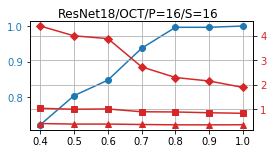

In [15]:
log_file = open('cnn_ivm_all.log', 'w')

for model, weight_file, fine_tuned_weight_file in zip(models, weight_files, fine_tuned_weight_files):

    weights_data = load_dict_from_hdf5(weight_file, gpu=False)
    file_tuned_weight_data = load_dict_from_hdf5(fine_tuned_weight_file, gpu=False)

    if model == VGG16:
        weights_data['fc8_W:0'] = file_tuned_weight_data['fc8_W:0']
        weights_data['fc8_b:0'] = file_tuned_weight_data['fc8_b:0']
    elif model == ResNet18:
        weights_data['fc:w'] = file_tuned_weight_data['fc:w']
        weights_data['fc:b'] = file_tuned_weight_data['fc:b']
    elif model == Inception3:
        weights_data['482.fc.weight'] = file_tuned_weight_data['482.fc.weight']
        weights_data['483.fc.bias'] = file_tuned_weight_data['483.fc.bias']
        
        
    for patch_size in patch_sizes:
        for stride in strides:

            if model == Inception3:
                image_size = 299
            else:
                image_size = 224

                    
            times_gpu_custom_global = []
            speedups_gpu_custom_global = []
            score_gpu_custom_global = []

            times_gpu_global = []
            speedups_gpu_global = []

            times_cpu_global = []
            speedups_cpu_global = []
            score_cpu_global = []
            
            for image_file_path in image_files:
                torch.cuda.synchronize()
                prev_time = time.time()
                with torch.no_grad():
                    x, prob, logit_index = full_inference_e2e(model, image_file_path, patch_size, stride,
                                           batch_size=128, gpu=True, image_size=image_size,
                                           x_size=image_size, y_size=image_size, weights_data=weights_data,
                                          n_labels=n_labels, c=c)

                torch.cuda.synchronize()
                full_inference_gpu_time = time.time() - prev_time

                message = str(model).split('.')[-1][:-2]+" Full Inference GPU Time: " + str(full_inference_gpu_time)
                print(message)
                log_file.write(message+"\n")
                
                torch.cuda.synchronize()
                prev_time = time.time()
                with torch.no_grad():
                    x, prob, logit_index = full_inference_e2e(model, image_file_path, patch_size, stride,
                                           batch_size=16, gpu=False, image_size=image_size,
                                           x_size=image_size, y_size=image_size, weights_data=weights_data,
                                          n_labels=n_labels, c=c)

                torch.cuda.synchronize()
                full_inference_cpu_time = time.time() - prev_time

                label = str(model).split('.')[-1][:-2]+" Full Inference CPU Time: " + str(full_inference_cpu_time)
                print(message)
                log_file.write(message+"\n")


                orig_hm = generate_heatmap(image_file_path, x, show=show, width=image_size, prob=prob,
                                           label=class_names[logit_index])

                gc.collect()
                torch.cuda.empty_cache()

                times_gpu_custom = []
                speedups_gpu_custom = []
                score_gpu_custom = []

                times_gpu = []
                speedups_gpu = []

                times_cpu = []
                speedups_cpu = []
                score_cpu = []

                for beta in taus:    
                    #CPU
                    prev_time = time.time()
                    x, prob, logit_index = inc_inference(beta, image_file_path, patch_size=patch_size, stride=stride,
                                gpu=False, version='v2', weights_data=weights_data, image_size=image_size)
                    
                    inc_inference_time = time.time()-prev_time
                    times_cpu.append(inc_inference_time)
                    speedups_cpu.append(full_inference_cpu_time/inc_inference_time)

                    hm = generate_heatmap(image_file_path, x, show=show, width=image_size, prob=prob,
                                          label=class_names[logit_index])

                    if hm.shape[0] < 7:
                        win_size=3
                    else:
                        win_size=None

                    ssim_score = ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size)
                    score_cpu.append(ssim_score)
                    message = str(model).split('.')[-1][:-2]+" CPU - BETA: " + str(beta) +" Inference Time: " +\
                        str(inc_inference_time) + " SSIM: " + str(ssim_score)
                    print(message)
                    log_file.write(label+"\n")
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    #GPU
                    prev_time = time.time()
                    x, prob, logit_index = inc_inference(beta, image_file_path, patch_size=patch_size, stride=stride, gpu=True,
                                      version='v2', weights_data=weights_data, image_size=image_size)
                    
                    inc_inference_time = time.time()-prev_time
                    times_gpu.append(inc_inference_time)
                    speedups_gpu.append(full_inference_gpu_time/inc_inference_time)
                    hm = generate_heatmap(image_file_path, x, show=show, width=image_size, prob=prob)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    message = str(model).split('.')[-1][:-2]+" GPU: " + str(beta) +" Inference Time: " +\
                        str(inc_inference_time)
                    print(message)
                    log_file.write(label+"\n")                    

                    #GPU Custom
                    prev_time = time.time()
                    x, prob, logit_index = inc_inference(beta, image_file_path, patch_size=patch_size, stride=stride, gpu=True,
                                    version='v1', weights_data=weights_data, image_size=image_size)
                    inc_inference_time = time.time()-prev_time
                    times_gpu_custom.append(inc_inference_time)
                    speedups_gpu_custom.append(full_inference_gpu_time/inc_inference_time)
                    hm = generate_heatmap(image_file_path, x, show=show, width=image_size, prob=prob, label=[logit_index])
                    if hm.shape[0] < 7:
                        win_size=3
                    else:
                        win_size=None
                    
                    ssim_score = ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size)
                    score_gpu_custom.append(ssim_score)
                    message = str(model).split('.')[-1][:-2]+" GPU Custom - BETA: " + str(beta) + \
                        " Inference Time: " + str(inc_inference_time) + " SSIM: " + str(ssim_score)
                    print(message)
                    log_file.write(label+"\n")              
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    
                times_gpu_custom_global.append(times_gpu_custom)
                speedups_gpu_custom_global.append(speedups_gpu_custom)
                score_gpu_custom_global.append(score_gpu_custom)

                times_gpu_global.append(times_gpu)
                speedups_gpu_global.append(speedups_gpu)

                times_cpu_global.append(times_cpu)
                speedups_cpu_global.append(speedups_cpu)
                score_cpu_global.append(score_cpu)
                

            fig = plt.figure(figsize=(4,2))
            ax1 = plt.subplot(1, 1, 1)

            temp_mean = []
            temp_ci = []
            for temp in zip(*score_gpu_custom_global):
                m, h = mean_confidence_interval(temp)
                temp_mean.append(m)
                temp_ci.append(h)
            ax1.errorbar(taus, temp_mean, yerr=temp_ci, marker='o', color='tab:blue')

            #ax1.set_xlabel(r'$\tau$')
            #ax1.set_ylabel('SSIM', color='tab:blue')
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            #ax1.xaxis.set_ticks(np.arange(0.4, 1.1, 0.1))
            #ax1.grid()
            ax1.xaxis.grid(True)

            ax2 = ax1.twinx()

            temp_mean = []
            temp_ci = []
            for temp in zip(*speedups_cpu_global):
                m, h = mean_confidence_interval(temp)
                temp_mean.append(m)
                temp_ci.append(h)
            ax2.errorbar(taus, temp_mean, yerr=temp_ci, marker='D', color='tab:red', label='CPU')

            temp_mean = []
            temp_ci = []
            for temp in zip(*speedups_gpu_global):
                m, h = mean_confidence_interval(temp)
                temp_mean.append(m)
                temp_ci.append(h)
            ax2.errorbar(taus, temp_mean, yerr=temp_ci, marker='^', color='tab:red', label='GPU')

            temp_mean = []
            temp_ci = []
            for temp in zip(*speedups_gpu_custom_global):
                m, h = mean_confidence_interval(temp)
                temp_mean.append(m)
                temp_ci.append(h)
            ax2.errorbar(taus, temp_mean, yerr=temp_ci, marker='s', color='tab:red', label='GPU Custom')

            #ax2.set_ylabel('Speedup', color='tab:red')
            ax2.tick_params(axis='y', labelcolor='tab:red')
            ax2.xaxis.set_ticks(np.arange(0.4, 1.1, 0.1))
            ax2.grid(True)

            #fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.025), frameon=False)
            #fig.tight_layout()
            fig_label = str(model).split('.')[-1][:-2]+"/"+str(dataset)+"/P="+str(patch_size)+"/S="+str(stride)
            fig.suptitle(fig_label)
            plt.savefig('./plots/'+fig_label.replace('/','-')+'.jpg')
            plt.show()